## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position

Import several pacakages and define helper function that shows images side by side

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os.path
%matplotlib inline

def draw_side_by_side(left, right, left_title='original', right_title='result', 
                      is_binary_left=False, is_binary_right=False, 
                      fontsize=30, figsize=(20,10)):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    f.tight_layout()
    
    if is_binary_left == True:
        left = np.dstack((left, left, left))*255
        
    if is_binary_right == True:
        right = np.dstack((right, right, right))*255

    ax1.imshow(left)
    ax1.set_title(left_title, fontsize=fontsize)

    ax2.imshow(right)
    ax2.set_title(right_title, fontsize=fontsize)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

---
## First, I'll compute the camera calibration using chessboard images

In [2]:
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y

cal_dist_pickle_filename = 'output_images/cal_dist_pickle.p'

mtx = None
dist = None

# if saved file exist, use it.
if os.path.isfile(cal_dist_pickle_filename):
    with open(cal_dist_pickle_filename, mode='rb') as f:
        data = pickle.load(f)
        mtx = data['mtx']
        dist = data['dist']
else:
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Make a list of calibration images
    images = glob.glob('camera_cal/calibration*.jpg')

    img_size = None
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
            img_size = (img.shape[1], img.shape[0])

    cv2.destroyAllWindows()
    
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)
    
    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    dist_pickle = {}
    dist_pickle["mtx"] = mtx
    dist_pickle["dist"] = dist
    pickle.dump( dist_pickle, open( "output_images/cal_dist_pickle.p", "wb" ) )

## Undistort a chessboard image.

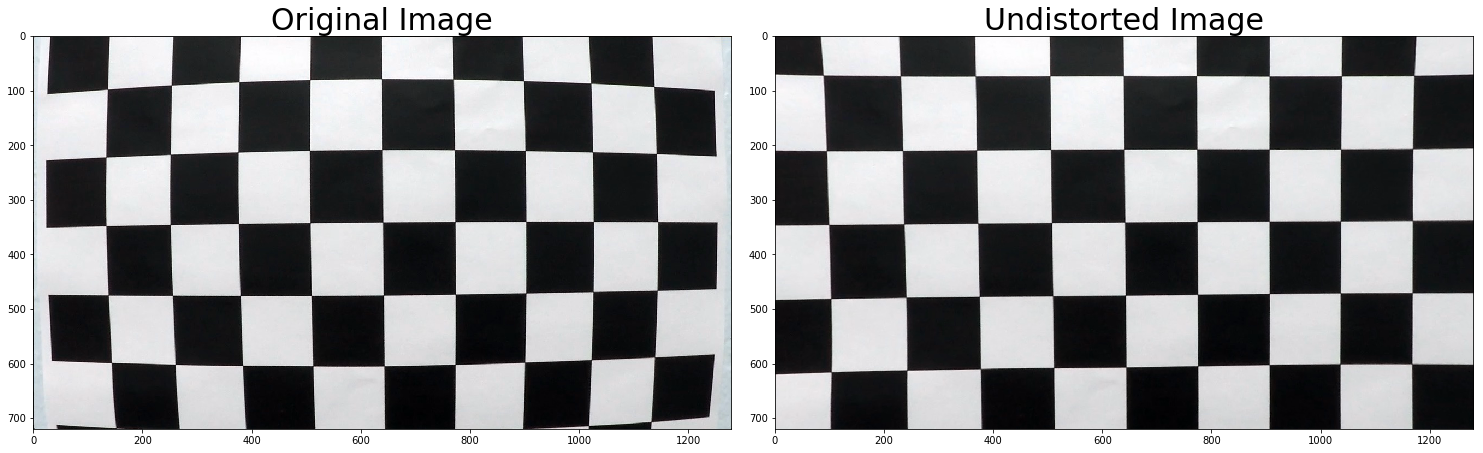

In [3]:
# Test undistortion on an image
undistort_filename = 'calibration1.jpg'
img = cv2.imread('camera_cal/' + undistort_filename)
img_size = (img.shape[1], img.shape[0])

dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite(os.path.join('output_images', undistort_filename),dst)

draw_side_by_side(img, dst, left_title='Original Image', right_title='Undistorted Image')

## Undistorted a test image. 

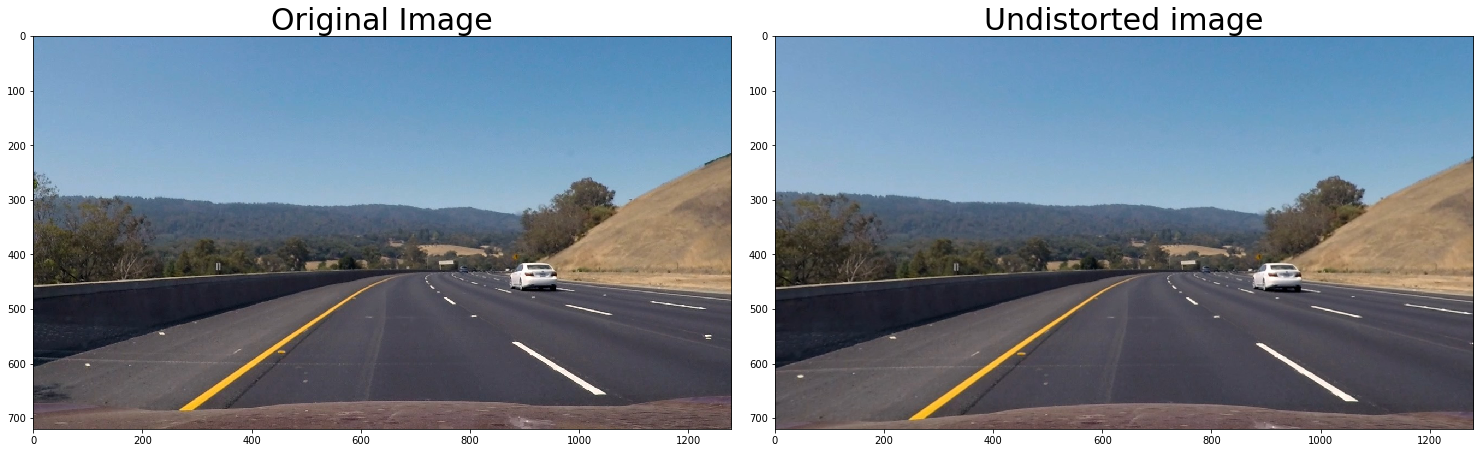

In [4]:
img = mpimg.imread('test_images/test3.jpg')

# camera calibration
undist = cv2.undistort(img, mtx, dist, None, mtx)

draw_side_by_side(img, undist, left_title='Original Image', right_title='Undistorted image')

## Pipeline including color and gradient thresholds

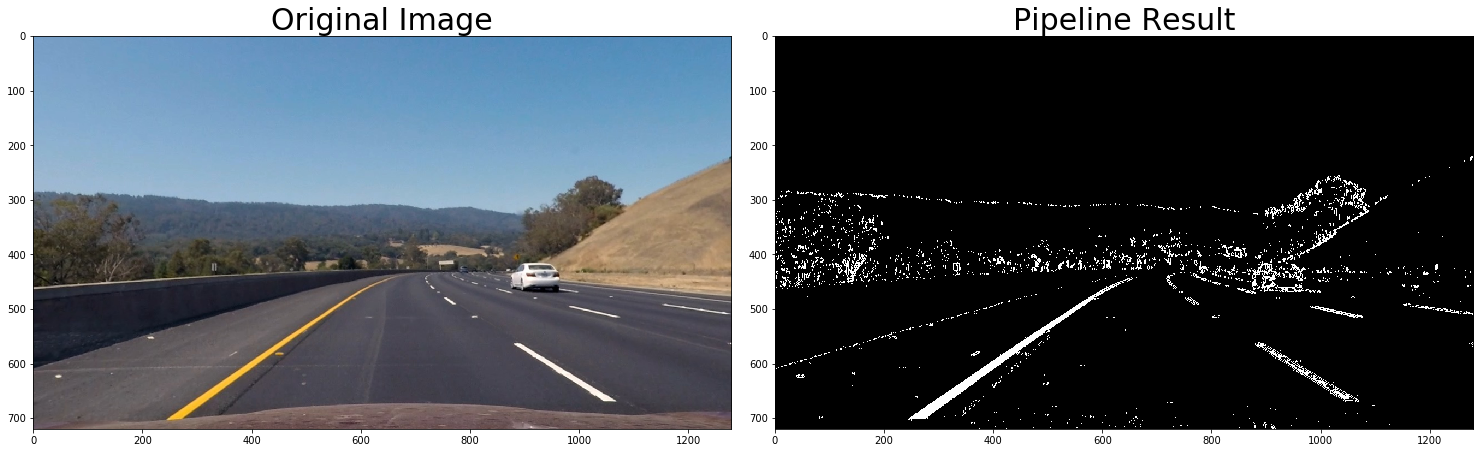

In [5]:
def pipeline(img, s_thresh=(180, 255), sx_thresh=(20, 100), sobel_kernel=3):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the L and S channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    
    # Use x gradient of light channel
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold saturation(color) channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    return combined_binary

binary_output = pipeline(undist)
draw_side_by_side(undist, binary_output, left_title='Original Image', right_title='Pipeline Result', is_binary_right=True)

## Coordinate for perspective transform

In [6]:
def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

offset = 0
src = np.float32(
     [[(img_size[0] / 2) - 60 + offset, img_size[1] / 2 + 100],
     [((img_size[0] / 6) - 20) + offset, img_size[1]],
     [(img_size[0] * 5 / 6) + 20 + offset, img_size[1]],
     [(img_size[0] / 2 + 60) + offset, img_size[1] / 2 + 100]])
dst = np.float32(
     [[(img_size[0] / 4), 0],
     [(img_size[0] / 4), img_size[1]],
     [(img_size[0] * 3 / 4), img_size[1]],
     [(img_size[0] * 3 / 4), 0]])
print(src, dst)

[[  580.           460.        ]
 [  193.33332825   720.        ]
 [ 1086.66662598   720.        ]
 [  700.           460.        ]] [[ 320.    0.]
 [ 320.  720.]
 [ 960.  720.]
 [ 960.    0.]]


In [7]:
# Matrix for inverse transform
Minv = cv2.getPerspectiveTransform(dst, src)

## Perspective transform of straight lines with bird-eye view

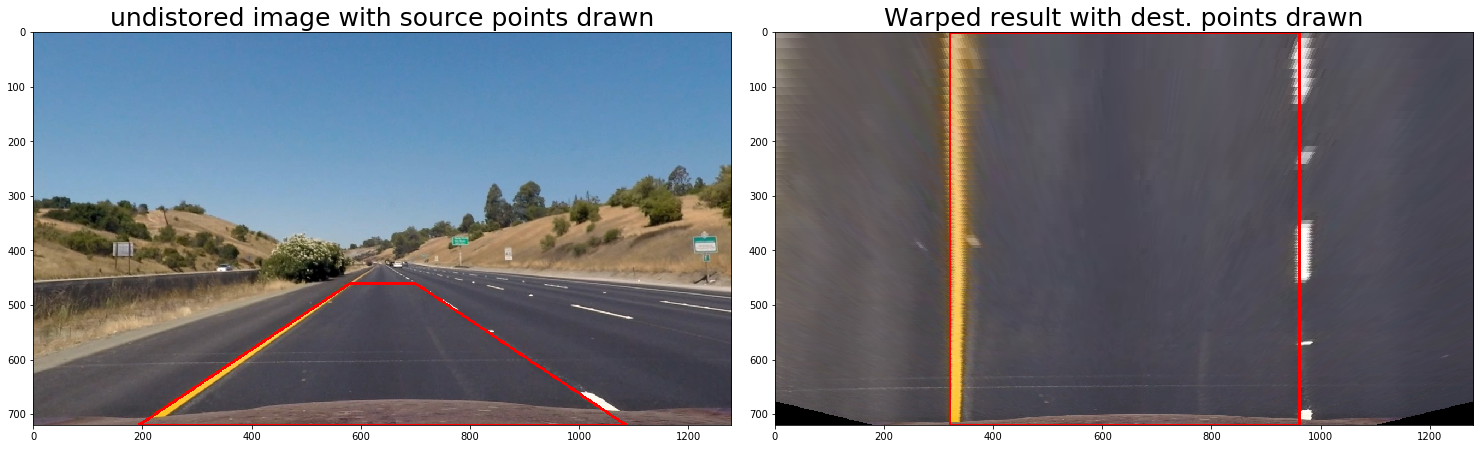

In [8]:
img_straight_line = mpimg.imread('test_images/straight_lines1.jpg')

undist_st = cv2.undistort(img_straight_line, mtx, dist, None, mtx)
warped_st = warper(undist_st, src, dst)

# Draw lines for perspective transform
cv2.polylines(undist_st, np.int_([src]), True, (255,0,0), 4)
cv2.polylines(warped_st, np.int_([dst]), True, (255,0,0), 4)

draw_side_by_side(undist_st, warped_st, 
                 'undistored image with source points drawn', 'Warped result with dest. points drawn',
                 fontsize=25)

## Line Finding Method: Peaks in a Histogram and sliding window

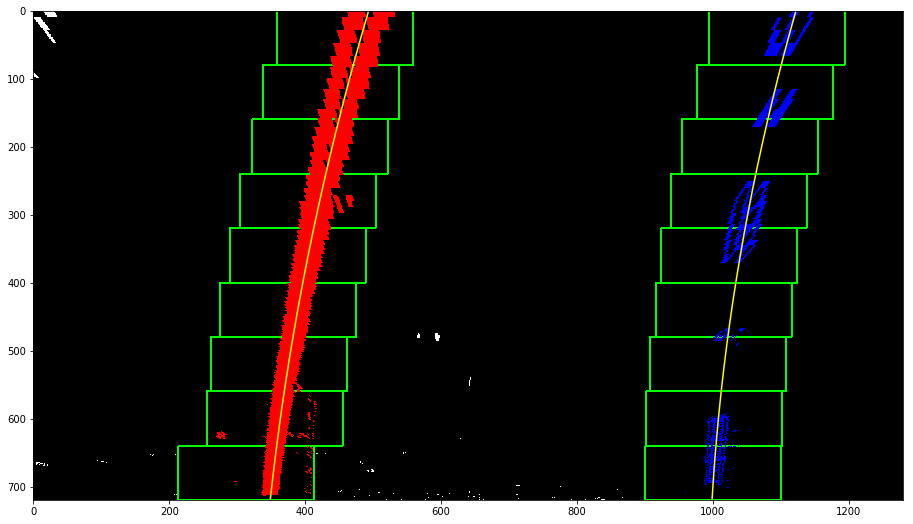

In [9]:
def find_lines(binary_warped, nwindows = 9, margin = 100, minpix = 50):
    # Find left and right lines in given image by combination of peack in histogram and sliding window
    # binary_warped - warped(bird-eye view) binary image for find lines
    # nwindows - the number of sliding windows
    # margin - the width of the windows +/- margin    
    # minpix - minimum number of pixels found to recenter window
    #
    # returns cordinates(indexes) of left and right line, image with sliding widows boxes    
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
#     print(midpoint, midpoint//10 )
    # there are 
    leftx_base = np.argmax(histogram[midpoint//10:midpoint])
    rightx_base = np.argmax(histogram[midpoint:-midpoint//10]) + midpoint

    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right line pixel indices
    left_line_inds = []
    right_line_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_line_inds.append(good_left_inds)
        right_line_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_line_inds = np.concatenate(left_line_inds)
    right_line_inds = np.concatenate(right_line_inds)

    return left_line_inds, right_line_inds, out_img

binary_warped = warper(binary_output, src, dst)

left_line_inds, right_line_inds, out_img = find_lines(binary_warped)

# Extract left and right line pixel positions
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
leftx = nonzerox[left_line_inds]
lefty = nonzeroy[left_line_inds] 
rightx = nonzerox[right_line_inds]
righty = nonzeroy[right_line_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_line_inds], nonzerox[left_line_inds]] = [255, 0, 0]
out_img[nonzeroy[right_line_inds], nonzerox[right_line_inds]] = [0, 0, 255]
plt.figure(figsize=(24, 9))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

## Skip the sliding windows step once you know where the lines are

In [10]:
def find_line_with_prev_result(nonzerox, nonzeroy, fit_array, margin=100):
    line_inds = ((nonzerox > (fit_array[0]*(nonzeroy**2) + fit_array[1]*nonzeroy + 
                    fit_array[2] - margin)) & (nonzerox < (fit_array[0]*(nonzeroy**2) + 
                    fit_array[1]*nonzeroy + fit_array[2] + margin)))
    return line_inds

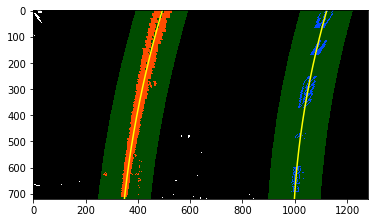

In [11]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
margin = 100
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

left_line_inds = find_line_with_prev_result(nonzerox, nonzeroy, left_fit, margin)
right_line_inds = find_line_with_prev_result(nonzerox, nonzeroy, right_fit, margin)

# Again, extract left and right line pixel positions
leftx = nonzerox[left_line_inds]
lefty = nonzeroy[left_line_inds] 
rightx = nonzerox[right_line_inds]
righty = nonzeroy[right_line_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_line_inds], nonzerox[left_line_inds]] = [255, 0, 0]
out_img[nonzeroy[right_line_inds], nonzerox[right_line_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')

## Measuring Curvature

In [12]:
def calc_curvature(value, polynomials):
    # http://www.intmath.com/applications-differentiation/8-radius-curvature.php
    return ((1 + (2*polynomials[0]*value + polynomials[1])**2)**1.5) / np.absolute(2*polynomials[0])

## Line class

In [13]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        # failed count
        self.failed_count = 0
        
    def set_binary_warped_image(self, binary_warped):
        nonzero = binary_warped.nonzero()
        self.nonzeroy = np.array(nonzero[0])
        self.nonzerox = np.array(nonzero[1]) 
        self.image_shape = binary_warped.shape
    
    def find_line_indexes(self, margin=100):
        fit_array = self.best_fit
        nonzerox, nonzeroy = self.nonzerox, self.nonzeroy
        
        line_inds = ((nonzerox > (fit_array[0]*(nonzeroy**2) + fit_array[1]*nonzeroy + 
                    fit_array[2] - margin)) & (nonzerox < (fit_array[0]*(nonzeroy**2) + 
                    fit_array[1]*nonzeroy + fit_array[2] + margin)))
        
        return line_inds
    
    def fit_n_calculate(self, line_inds):
        if self.nonzeroy == None:
            raise Exception('set_binary_warped_image() first!')
           
        # extract line pixel positions
        self.allx = self.nonzerox[line_inds]
        self.ally = self.nonzeroy[line_inds]
        ploty = np.linspace(0, self.image_shape[0]-1, self.image_shape[0])
        
        # Append previous best pixel indexes
        if self.bestx != None:
            self.allx = np.append(self.allx, self.bestx).astype(np.int)
            self.ally = np.append(self.ally, ploty).astype(np.int)
        
        # Fit a second order polynomial 
        fit_array = np.polyfit(self.ally, self.allx, 2)       
        x_array = fit_array[0]*ploty**2 + fit_array[1]*ploty + fit_array[2]
        
        # radius of curvature
        y_eval = np.max(ploty)

        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension

        # Fit new polynomials to x,y in world space
        fit_cr = np.polyfit(ploty*ym_per_pix, x_array*xm_per_pix, 2)

        # Calculate the new radii of curvature
        radius = calc_curvature(y_eval*ym_per_pix, fit_cr)
        center = self.image_shape[1] / 2
        
        valid = False
        
        # if this is the first frame or reset
        if self.detected == False:
            self.current_fit = fit_array
            self.best_fit = self.current_fit
            self.bestx = x_array
            self.recent_xfitted.append(self.bestx)
            self.radius_of_curvature = radius
            self.line_base_pos = np.abs(center - self.bestx[-1]) * xm_per_pix
            self.detected = True
        else:
            # sanity check for radius of curvature
            if (self.radius_of_curvature * 0.25 < radius < self.radius_of_curvature * 4):
                valid = True

            # sanity check for line base position    
            line_base_pos = np.abs(center - self.bestx[-1]) 
            prev_line_base = self.line_base_pos / xm_per_pix
            if (prev_line_base - 20 < line_base_pos < prev_line_base + 20):
                valid = True

            # if passed sanity check then update
            if valid == True:    
                recent_five = self.recent_xfitted[-4:]
                recent_five.append(x_array)
                average_x = np.mean(recent_five, axis=0)

                self.current_fit = np.polyfit(ploty, average_x, 2)

                if self.best_fit != None:
                    self.diffs = self.best_fit - self.current_fit
                self.best_fit = self.current_fit

                self.bestx = self.best_fit[0]*ploty**2 + self.best_fit[1]*ploty + self.best_fit[2]
                self.recent_xfitted.append(self.bestx)

                fit_cr = np.polyfit(ploty*ym_per_pix, self.bestx*xm_per_pix, 2)
                self.radius_of_curvature = calc_curvature(y_eval*ym_per_pix, fit_cr)
                self.line_base_pos = np.abs(center - self.bestx[-1]) * xm_per_pix
            
            # if failed sanity check 5 times in a row, reset 
            else:
                self.failed_count += 1
                if self.failed_count > 5:
                    self.detected = False
                    self.failed_count = 0
                    self.recent_xfitted = []
                    self.bestx = None
                    self.best_fit = None
        return valid


## Process image with whole pipeline including radius and center calculation

/Users/yhbyhb/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel_launcher.py:43: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


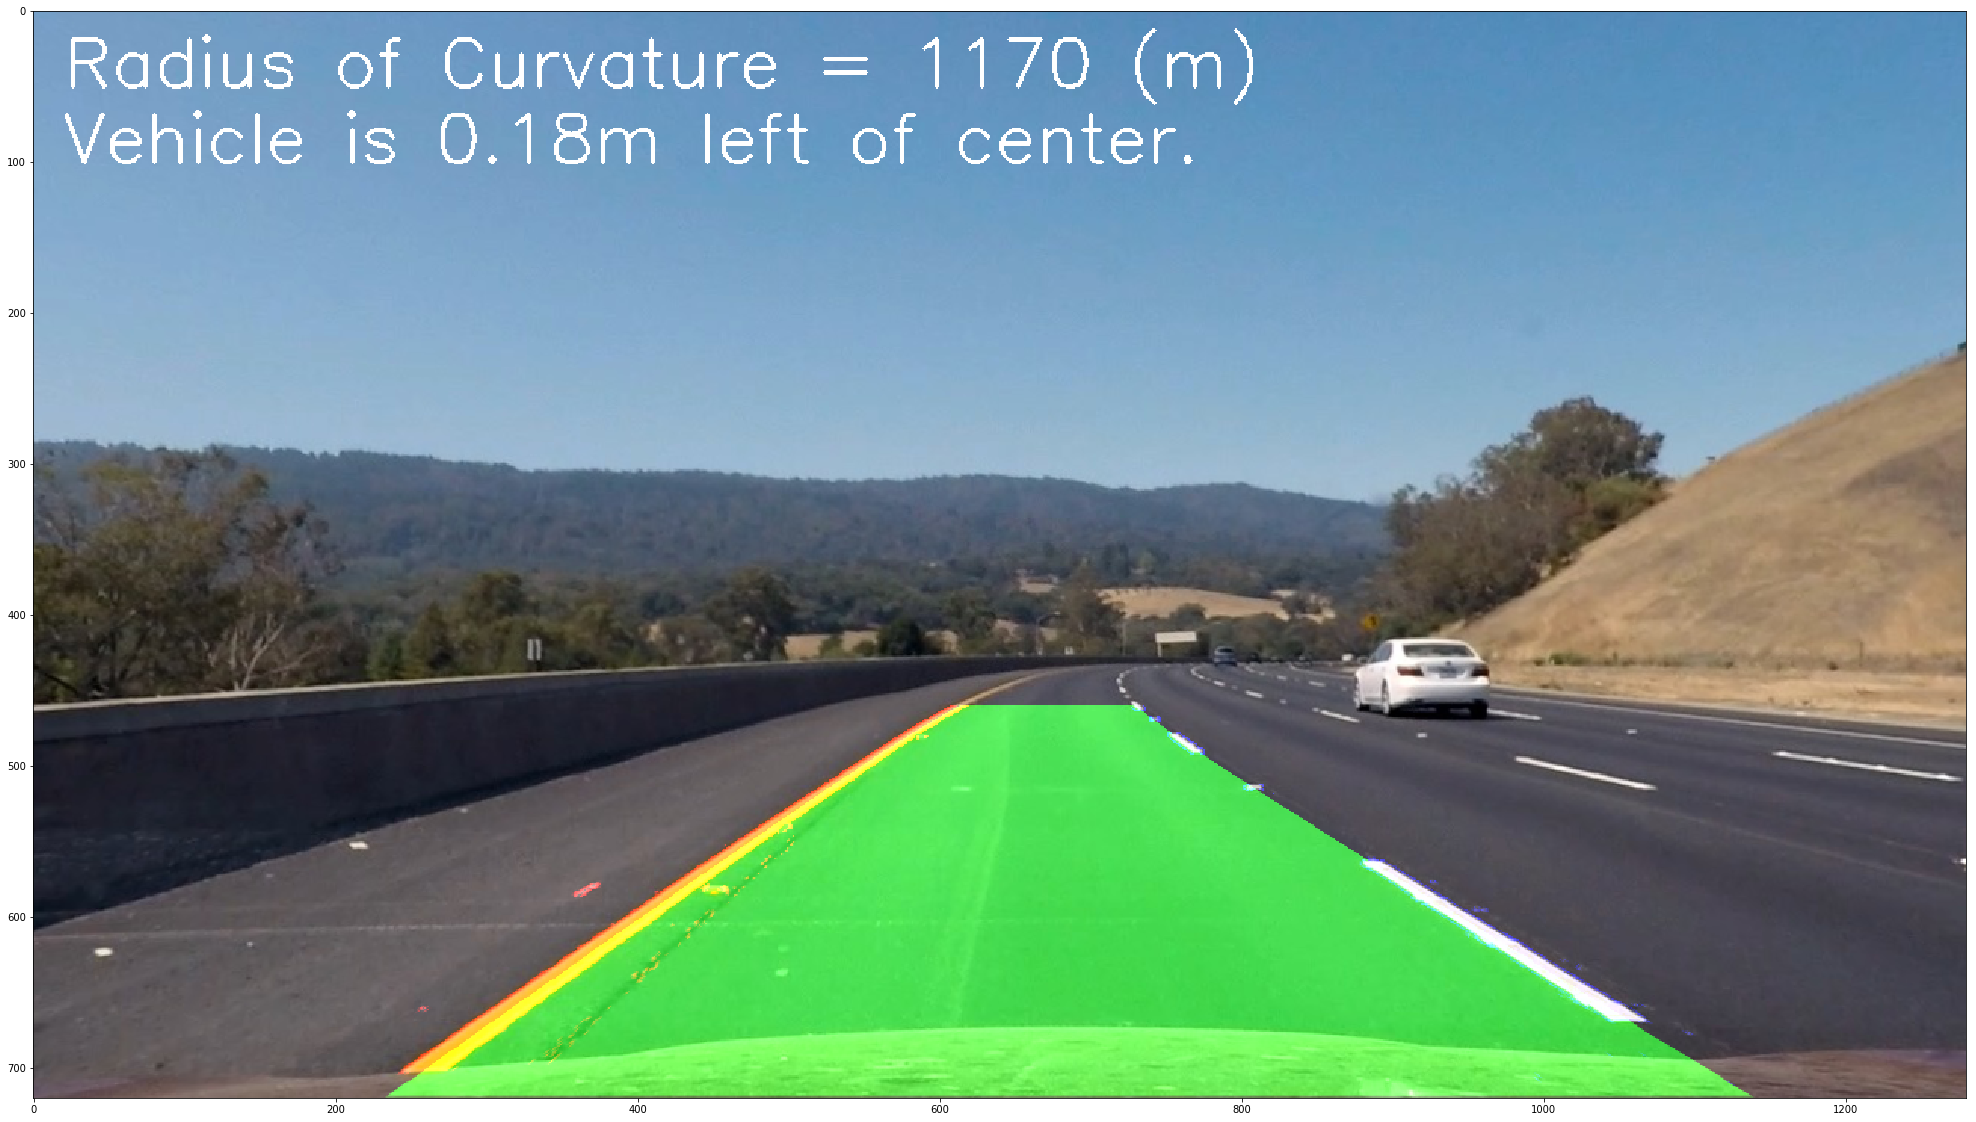

In [14]:
left_line = Line()
right_line = Line()

# function for whole process including camera calibration to perspective transform
# Returns green colored lane, red left and 
def process_image(image):
    undist = cv2.undistort(image, mtx, dist, None, mtx)
    binary_output = pipeline(undist)
    binary_warped = warper(binary_output, src, dst)
     
    left_line.set_binary_warped_image(binary_warped)
    right_line.set_binary_warped_image(binary_warped)

    left_line_inds = None
    right_line_inds = None    
    
    if left_line.detected == False or right_line.detected == False:
        left_line_inds, right_line_inds, _ = find_lines(binary_warped)
    
    if left_line.detected == True:
        left_line_inds = left_line.find_line_indexes()
    
    if right_line.detected == True:
        right_line_inds = right_line.find_line_indexes()
        
    left_line.fit_n_calculate(left_line_inds)
    right_line.fit_n_calculate(right_line_inds)
    
    left_fit = left_line.current_fit
    right_fit = right_line.current_fit  

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_line.bestx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_line.bestx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    warped = np.zeros_like(binary_warped).astype(np.uint8)
    warped_zero = np.dstack((warped, warped, warped))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(warped_zero, np.int_([pts]), (0,255, 0))
    road = warped_zero.copy()
    lane = np.zeros_like(out_img)
    lane[left_line.ally, left_line.allx] = [255, 0, 0]
    lane[right_line.ally, right_line.allx] = [0, 0, 255]
    road[lane.nonzero()] = 0
    road[:,:,0] = lane[:,:,0]
    road[:,:,2] = lane[:,:,2]
    # plt.imshow(road)

    # Warp image that colored lines and lane back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(road, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.6, 0)
    
    # radius of curvature
    radius = (left_line.radius_of_curvature + right_line.radius_of_curvature) / 2.0
    radius_text = "Radius of Curvature = {:.0f} (m)".format(radius)
    
    # distance from center
    diff =  (left_line.line_base_pos - right_line.line_base_pos) / 2.0
    direction = 'right' if diff > 0 else 'left'
    center_text = "Vehicle is {:.2f}m {} of center.".format(abs(diff), direction)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    position = (20,50)
    fontScale = 1.5
    fontColor = (255,255,255)
    lineType = 2

    cv2.putText(result, radius_text, (20, 50), font, fontScale, fontColor, lineType)
    cv2.putText(result, center_text, (20, 100), font, fontScale, fontColor, lineType)
    
    return result

# Test pipeline with an image
plt.figure(figsize=(40,20))
plt.imshow(process_image(img))

## Test on videoes

In [15]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [16]:
output = 'output.mp4'

left_line = Line()
right_line = Line()

# subclip to diffult case
# clip1 = VideoFileClip("project_video.mp4").subclip(20,25)
# clip1 = VideoFileClip("project_video.mp4").subclip(37,43)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video output.mp4
[MoviePy] Writing video output.mp4


100%|█████████▉| 1260/1261 [06:46<00:00,  2.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output.mp4 

CPU times: user 5min 58s, sys: 1min 46s, total: 7min 45s
Wall time: 6min 48s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))